# LOCA2 CMIP6 SSP585: Cones of Uncertainty

The purpose of this notebook is to plot the annual precipitation and annual average temperature cones of uncertainty across 2025-2065 for LOCA2 downscaled, CMIP6, ssp585 simulation results

## Parameters and Imports

In [1]:
%matplotlib inline

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from IPython.display import display, HTML
from copy import deepcopy

In [3]:
IN_DIR1 = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\LOCA2'
IN_DIR2 = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\DayMet_GridIntersect'
OUT_DIR = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\LOCA2\Cones_of_Uncertainty'

In [4]:
MODEL_DICT = { 51 : ["CMIP6", ["ssp245", "ssp585"], ], 
               52 : ["CMIP6", ["ssp245", "ssp585"], ], 
               53 : ["CMIP6", ["ssp245", "ssp585"], ], 
               55 : ["CMIP6", ["ssp245", "ssp585"], ], 
               56 : ["CMIP6", ["ssp245", "ssp585"], ], 
               57 : ["CMIP6", ["ssp245", "ssp585"], ], 
               58 : ["CMIP6", ["ssp245", "ssp585"], ], 
               59 : ["CMIP6", ["ssp245", "ssp585"], ], 
               60 : ["CMIP6", ["ssp245", "ssp585"], ], 
               61 : ["CMIP6", ["ssp245", "ssp585"], ], 
               62 : ["CMIP6", ["ssp245", "ssp585"], ], 
               63 : ["CMIP6", ["ssp245", "ssp585"], ], 
               64 : ["CMIP6", ["ssp245", "ssp585"], ], 
               65 : ["CMIP6", ["ssp245", "ssp585"], ], 
               66 : ["CMIP6", ["ssp245", "ssp585"], ], 
               67 : ["CMIP6", ["ssp245", "ssp585"], ], 
               68 : ["CMIP6", ["ssp245", "ssp585"], ], 
               69 : ["CMIP6", ["ssp245", "ssp585"], ], 
               70 : ["CMIP6", ["ssp245", "ssp585"], ], 
               71 : ["CMIP6", ["ssp245", "ssp585"], ], 
               72 : ["CMIP6", ["ssp245", "ssp585"], ], 
               73 : ["CMIP6", ["ssp245", "ssp585"], ], 
               74 : ["CMIP6", ["ssp245", "ssp585"], ], }
MODEL_KEYS = list( MODEL_DICT.keys() )

In [5]:
tSen = "ssp585"

In [6]:
StartTS = pd.Timestamp( 2025, 1, 1, )
StopTS = pd.Timestamp( 2065, 12, 31, 23, 59, )
YearsIndexer = [ pd.Timestamp(x, 7, 1, 0) for x in range(StartTS.year, StopTS.year + 1) ]
len( YearsIndexer )

41

In [7]:
fillIndexer = deepcopy( YearsIndexer )
fillIndexer[0] = pd.Timestamp(2025, 1, 1, 0)
fillIndexer[len(fillIndexer)-1] = pd.Timestamp(2065, 12, 31, 23, 59, )

In [8]:
# make the Date indices
NumPolyPlotPts = len( fillIndexer )
NumPolyPlotPts

41

In [9]:
# make the time polygon list
DTTimeList = deepcopy( fillIndexer )
BackDTList = deepcopy( fillIndexer )
BackDTTL = BackDTList[::-1]
DTTimeList.extend( BackDTTL )

In [10]:
ProjFileRoot = "Mod_%02d_%s_2023through2065_%s_DF.pkl"

In [11]:
# full basin intersection dictionary
InFiler = os.path.normpath( os.path.join( IN_DIR2, "LOCA2BasWeightsGDF.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    BasWeightsDF = pickle.load( IF )
# end with
BAS_KEYS = sorted( BasWeightsDF.keys() )

In [12]:
ColsList = list()
for mKey in MODEL_KEYS:
    ColsList.append( "M%02d_%s" % (mKey, tSen) )
# end for

In [13]:
OurQs = np.array( [ round( 0.05 * x, 2 ) for x in range(21) ], dtype=np.float32 )
NumQs = len( OurQs )
NumQs

21

In [14]:
TSTicks = [ pd.Timestamp( 2025, 1, 1, ), pd.Timestamp( 2030, 1, 1, ), pd.Timestamp( 2035, 1, 1, ), pd.Timestamp( 2040, 1, 1, ),
            pd.Timestamp( 2045, 1, 1, ), pd.Timestamp( 2050, 1, 1, ), pd.Timestamp( 2055, 1, 1, ), pd.Timestamp( 2060, 1, 1, ),
            pd.Timestamp( 2065, 1, 1, ), ]
TSLabels = [ 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, ]

In [15]:
TempYVals = [ 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, ]
PreYVals = [ 0.0, 250.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0, 1750.0, 2000.0 ]

## Test Basin

In [16]:
mKey = MODEL_KEYS[0]
bas = BAS_KEYS[0]
bas

'Blanco'

In [17]:
AnnualPreDepDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )
AnnualTempMeanDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )

In [18]:
for mKey in MODEL_KEYS:
    curCol = "M%02d_%s" % (mKey, tSen)
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (mKey, tSen, bas) ) )
    curDF = pd.read_pickle( InFiler )
    cPreDF = curDF[["Year", "Pre_mm"]].copy()
    cTmpDF = curDF[["Year", "AveT_C"]].copy()
    cYrPreDF = cPreDF.groupby(by="Year").sum()
    cYrTmpDF = cTmpDF.groupby(by="Year").mean()
    cYrPreDF = cYrPreDF[(cYrPreDF.index >= StartTS.year) & (cYrPreDF.index <= StopTS.year)].copy()
    cYrTmpDF = cYrTmpDF[(cYrTmpDF.index >= StartTS.year) & (cYrTmpDF.index <= StopTS.year)].copy()
    AnnualPreDepDF[curCol] = cYrPreDF["Pre_mm"].to_numpy(dtype=np.float32)
    AnnualTempMeanDF[curCol] = cYrTmpDF["AveT_C"].to_numpy(dtype=np.float32)
# end for

In [19]:
display( HTML( AnnualPreDepDF.describe().to_html() ) )

,M51_ssp585,M52_ssp585,M53_ssp585,M55_ssp585,M56_ssp585,M57_ssp585,M58_ssp585,M59_ssp585,M60_ssp585,M61_ssp585,M62_ssp585,M63_ssp585,M64_ssp585,M65_ssp585,M66_ssp585,M67_ssp585,M68_ssp585,M69_ssp585,M70_ssp585,M71_ssp585,M72_ssp585,M73_ssp585,M74_ssp585
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,797.739319,809.662659,884.422852,754.925049,826.672363,906.505737,726.893921,843.581665,782.708374,740.576843,746.440918,763.103943,846.020691,945.573242,792.705139,750.312866,888.816895,862.399658,823.718079,739.481506,765.751892,796.473450,744.514221
std,237.853958,226.523392,343.146851,176.653946,240.469437,333.070404,205.773376,248.206253,254.315613,224.324661,249.911514,209.214890,230.310684,275.411530,268.899109,217.349854,332.698792,211.459686,241.902222,218.058838,236.026337,253.031509,254.802872
min,323.989594,393.616913,313.924255,377.149200,385.423889,417.047852,391.526520,362.926849,354.077850,340.399567,289.056946,436.255615,395.390564,410.128754,384.416962,406.407562,376.179626,374.963959,463.102020,342.702606,343.189301,398.848969,320.273712
25%,616.109314,653.735291,704.291687,663.959229,645.060974,652.414795,572.041443,673.858765,616.709106,552.669250,610.574646,608.798279,689.803223,763.979797,551.914307,585.546448,647.211731,683.288696,669.272339,584.644470,620.263733,600.326965,519.400757
50%,808.072571,785.370789,823.643616,763.529297,823.066833,889.751953,673.447632,823.938660,755.509216,752.557312,688.515137,747.196411,833.775391,878.889771,830.668945,705.543396,811.897095,881.385498,750.582275,701.263062,737.424316,777.427795,769.956726
75%,910.409485,943.062744,982.623474,855.831787,944.608032,1015.477966,836.430298,989.457703,907.745178,873.773865,876.798340,853.524719,1003.315857,1128.563843,887.255066,883.023865,1001.105835,1027.409424,975.737915,855.902161,895.393860,932.109009,887.480286
max,1294.155396,1367.087402,2009.149170,1152.447754,1382.509399,1923.784058,1402.571655,1442.142578,1479.995850,1266.488159,1691.774292,1370.296875,1416.080322,1633.526367,1515.388428,1259.475708,1959.089844,1392.150146,1464.027954,1278.607544,1339.926025,1362.525757,1447.801514


In [20]:
display( HTML( AnnualTempMeanDF.describe().to_html() ) )

,M51_ssp585,M52_ssp585,M53_ssp585,M55_ssp585,M56_ssp585,M57_ssp585,M58_ssp585,M59_ssp585,M60_ssp585,M61_ssp585,M62_ssp585,M63_ssp585,M64_ssp585,M65_ssp585,M66_ssp585,M67_ssp585,M68_ssp585,M69_ssp585,M70_ssp585,M71_ssp585,M72_ssp585,M73_ssp585,M74_ssp585
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,22.842051,22.008486,22.264441,21.028154,22.017153,21.575161,21.496088,21.322382,21.720327,21.407677,21.240576,21.608253,21.816933,21.664534,21.911119,20.992563,22.391075,21.642954,21.752113,20.986198,21.865669,21.392879,21.336998
std,1.205102,0.996333,0.766003,0.669284,0.736894,0.907569,0.804435,0.811826,1.013346,0.804655,0.693791,0.837950,0.905681,1.216304,0.904171,0.855550,0.846337,0.932757,0.725462,0.707277,0.767087,0.996400,1.057299
min,20.647429,19.999851,21.048897,19.268974,20.246689,19.853388,19.680937,19.655300,20.041750,19.387243,20.362652,19.887024,20.257149,19.364536,20.355392,19.275124,21.071295,19.920197,20.149809,19.388224,20.548260,19.295338,17.790129
25%,21.955980,21.328733,21.711924,20.517221,21.524870,21.023085,20.940180,20.669334,21.034592,21.000296,20.694471,21.075912,21.142588,20.738440,21.194975,20.171225,21.718880,20.908659,21.189653,20.390184,21.251698,20.649195,20.762501
50%,22.833687,21.788853,22.214588,21.092398,21.957575,21.579054,21.547474,21.433809,21.560102,21.401541,21.158382,21.676481,21.751791,21.568651,21.739601,21.120630,22.227757,21.616209,21.646261,21.045172,21.906321,21.244637,21.353596
75%,23.949759,22.571821,22.960089,21.507143,22.459831,22.278181,22.043425,21.832294,22.366943,21.972351,21.687527,22.306444,22.365038,22.630285,22.619732,21.579815,23.111052,22.332289,22.221584,21.551769,22.425953,22.089205,22.020210
max,25.067726,24.161926,23.878551,22.152309,24.054163,23.057688,23.488214,22.739326,24.089970,23.481894,22.975843,22.956631,23.672556,23.942516,23.623285,22.555391,24.442724,23.822315,23.161367,22.333977,23.322262,23.641888,23.288811


In [21]:
PreQDict = dict()
AveTQDict = dict()

In [22]:
for cQ in OurQs.tolist():
    curLabel = "q%3.2f" % cQ
    PreQDict[curLabel] = AnnualPreDepDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
    AveTQDict[curLabel] = AnnualTempMeanDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
# end for

In [23]:
PreQDict["Mean"] = AnnualPreDepDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["Mean"] = AnnualTempMeanDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
PreQDict["StDev"] = AnnualPreDepDF.std(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["StDev"] = AnnualTempMeanDF.std(axis=1).to_numpy(dtype=np.float32).flatten()

In [24]:
FutQsPre = pd.DataFrame( index=YearsIndexer, data=PreQDict )
FutQsTemp = pd.DataFrame( index=YearsIndexer, data=AveTQDict )

In [25]:
PQ5thList = FutQsPre["q0.05"].tolist()
PQ25thList = FutQsPre["q0.25"].tolist()
PQ75thList = FutQsPre["q0.75"].tolist()
PQ95thList = FutQsPre["q0.95"].tolist()

In [26]:
TQ5thList = FutQsTemp["q0.05"].tolist()
TQ25thList = FutQsTemp["q0.25"].tolist()
TQ75thList = FutQsTemp["q0.75"].tolist()
TQ95thList = FutQsTemp["q0.95"].tolist()

In [27]:
# 5th - 95th Envelope
PEnv5to95List = deepcopy( PQ5thList )
Back95List = deepcopy( PQ95thList )
Back95DTTL = Back95List[::-1]
PEnv5to95List.extend( Back95DTTL )

In [28]:
# 25th - 75th Envelope
PEnv25to75List = deepcopy( PQ25thList )
Back75List = deepcopy( PQ75thList )
Back75DTTL = Back75List[::-1]
PEnv25to75List.extend( Back75DTTL )

In [29]:
# 5th - 95th Envelope
TEnv5to95List = deepcopy( TQ5thList )
Back95List = deepcopy( TQ95thList )
Back95DTTL = Back95List[::-1]
TEnv5to95List.extend( Back95DTTL )

In [30]:
# 25th - 75th Envelope
TEnv25to75List = deepcopy( TQ25thList )
Back75List = deepcopy( TQ75thList )
Back75DTTL = Back75List[::-1]
TEnv25to75List.extend( Back75DTTL )

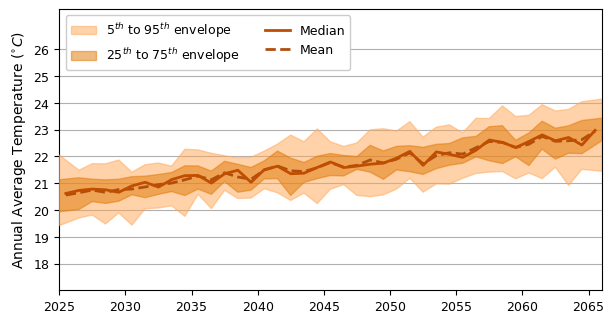

In [31]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, TEnv5to95List, color='xkcd:pale orange', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, TEnv25to75List, color='xkcd:pumpkin', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsTemp.index, FutQsTemp["q0.50"].tolist(), color='xkcd:burnt orange',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsTemp.index, FutQsTemp["Mean"].tolist(), color='xkcd:burnt sienna',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Average Temperature ($^{\circ}C$)', fontsize=10)
ax11.set_yticks( TempYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]) )
ax11.set_ylim( (17, 27.5 ) )
ax11.legend( loc='upper left', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
#Fig1.savefig( OutPDF, dpi=600.0 )
#Fig1.savefig( OutSVG, dpi=600.0 )
#Fig1.savefig( OutPNG, dpi=600.0 )

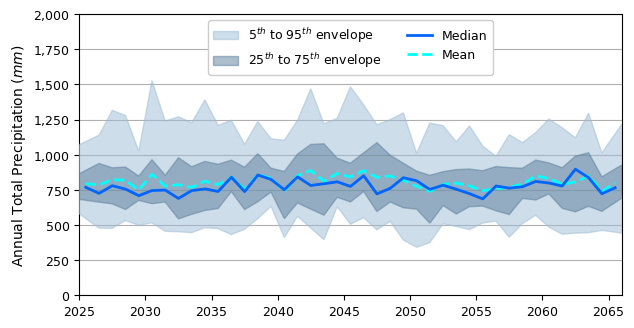

In [32]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, PEnv5to95List, color='xkcd:light grey blue', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, PEnv25to75List, color='xkcd:steel blue', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsPre.index, FutQsPre["q0.50"].tolist(), color='xkcd:bright blue',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsPre.index, FutQsPre["Mean"].tolist(), color='xkcd:cyan',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Total Precipitation ($mm$)', fontsize=10)
ax11.set_yticks( PreYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]))
ax11.set_ylim( (PreYVals[0], PreYVals[len(PreYVals)-1]) )
ax11.legend( loc='upper center', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
#Fig1.savefig( OutPDF, dpi=600.0 )
#Fig1.savefig( OutSVG, dpi=600.0 )
#Fig1.savefig( OutPNG, dpi=600.0 )

## Aggregate and Process by Basin

In [33]:
PreAnnModsDict = dict()
TmpAnnModsDict = dict()
PreBasinQsDict = dict()
TmpBasinQsDict = dict()

### Blanco

In [34]:
bCnt = 0
bas = BAS_KEYS[bCnt]
bas

'Blanco'

In [35]:
AnnualPreDepDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )
AnnualTempMeanDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )

In [36]:
for mKey in MODEL_KEYS:
    curCol = "M%02d_%s" % (mKey, tSen)
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (mKey, tSen, bas) ) )
    curDF = pd.read_pickle( InFiler )
    cPreDF = curDF[["Year", "Pre_mm"]].copy()
    cTmpDF = curDF[["Year", "AveT_C"]].copy()
    cYrPreDF = cPreDF.groupby(by="Year").sum()
    cYrTmpDF = cTmpDF.groupby(by="Year").mean()
    cYrPreDF = cYrPreDF[(cYrPreDF.index >= StartTS.year) & (cYrPreDF.index <= StopTS.year)].copy()
    cYrTmpDF = cYrTmpDF[(cYrTmpDF.index >= StartTS.year) & (cYrTmpDF.index <= StopTS.year)].copy()
    AnnualPreDepDF[curCol] = cYrPreDF["Pre_mm"].to_numpy(dtype=np.float32)
    AnnualTempMeanDF[curCol] = cYrTmpDF["AveT_C"].to_numpy(dtype=np.float32)
# end for

In [37]:
PreAnnModsDict[bas] = AnnualPreDepDF.copy()
TmpAnnModsDict[bas] = AnnualTempMeanDF.copy()

In [38]:
PreQDict = dict()
AveTQDict = dict()

In [39]:
for cQ in OurQs.tolist():
    curLabel = "q%3.2f" % cQ
    PreQDict[curLabel] = AnnualPreDepDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
    AveTQDict[curLabel] = AnnualTempMeanDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
# end for

In [40]:
PreQDict["Mean"] = AnnualPreDepDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["Mean"] = AnnualTempMeanDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
PreQDict["StDev"] = AnnualPreDepDF.std(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["StDev"] = AnnualTempMeanDF.std(axis=1).to_numpy(dtype=np.float32).flatten()

In [41]:
FutQsPre = pd.DataFrame( index=YearsIndexer, data=PreQDict )
FutQsTemp = pd.DataFrame( index=YearsIndexer, data=AveTQDict )

In [42]:
PreBasinQsDict[bas] = FutQsPre.copy()
TmpBasinQsDict[bas] = FutQsTemp.copy()

In [43]:
PQ5thList = FutQsPre["q0.05"].tolist()
PQ25thList = FutQsPre["q0.25"].tolist()
PQ75thList = FutQsPre["q0.75"].tolist()
PQ95thList = FutQsPre["q0.95"].tolist()

In [44]:
TQ5thList = FutQsTemp["q0.05"].tolist()
TQ25thList = FutQsTemp["q0.25"].tolist()
TQ75thList = FutQsTemp["q0.75"].tolist()
TQ95thList = FutQsTemp["q0.95"].tolist()

In [45]:
# 5th - 95th Envelope
PEnv5to95List = deepcopy( PQ5thList )
Back95List = deepcopy( PQ95thList )
Back95DTTL = Back95List[::-1]
PEnv5to95List.extend( Back95DTTL )

In [46]:
# 25th - 75th Envelope
PEnv25to75List = deepcopy( PQ25thList )
Back75List = deepcopy( PQ75thList )
Back75DTTL = Back75List[::-1]
PEnv25to75List.extend( Back75DTTL )

In [47]:
# 5th - 95th Envelope
TEnv5to95List = deepcopy( TQ5thList )
Back95List = deepcopy( TQ95thList )
Back95DTTL = Back95List[::-1]
TEnv5to95List.extend( Back95DTTL )

In [48]:
# 25th - 75th Envelope
TEnv25to75List = deepcopy( TQ25thList )
Back75List = deepcopy( TQ75thList )
Back75DTTL = Back75List[::-1]
TEnv25to75List.extend( Back75DTTL )

In [49]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.png" % bas ) )

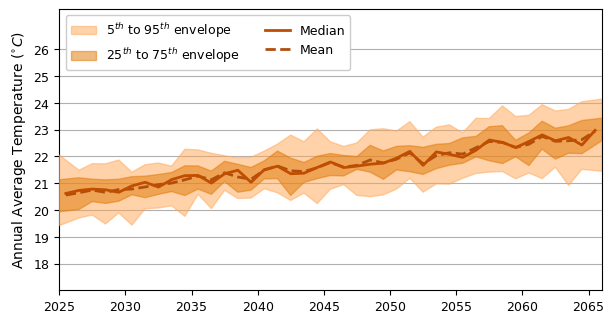

In [50]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, TEnv5to95List, color='xkcd:pale orange', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, TEnv25to75List, color='xkcd:pumpkin', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsTemp.index, FutQsTemp["q0.50"].tolist(), color='xkcd:burnt orange',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsTemp.index, FutQsTemp["Mean"].tolist(), color='xkcd:burnt sienna',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Average Temperature ($^{\circ}C$)', fontsize=10)
ax11.set_yticks( TempYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]) )
ax11.set_ylim( (17, 27.5 ) )
ax11.legend( loc='upper left', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

In [51]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.png" % bas ) )

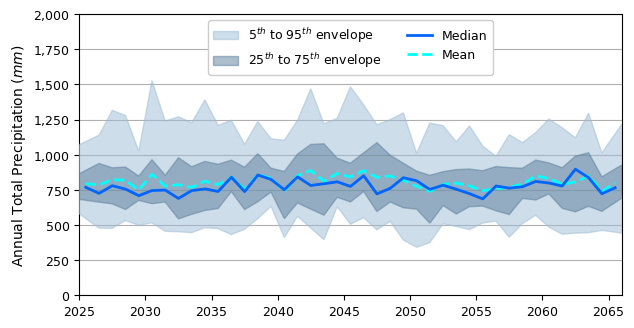

In [52]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, PEnv5to95List, color='xkcd:light grey blue', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, PEnv25to75List, color='xkcd:steel blue', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsPre.index, FutQsPre["q0.50"].tolist(), color='xkcd:bright blue',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsPre.index, FutQsPre["Mean"].tolist(), color='xkcd:cyan',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Total Precipitation ($mm$)', fontsize=10)
ax11.set_yticks( PreYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]))
ax11.set_ylim( (PreYVals[0], PreYVals[len(PreYVals)-1]) )
ax11.legend( loc='upper center', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

### Cibolo

In [53]:
bCnt += 1
bas = BAS_KEYS[bCnt]
bas

'Cibolo'

In [54]:
AnnualPreDepDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )
AnnualTempMeanDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )

In [55]:
for mKey in MODEL_KEYS:
    curCol = "M%02d_%s" % (mKey, tSen)
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (mKey, tSen, bas) ) )
    curDF = pd.read_pickle( InFiler )
    cPreDF = curDF[["Year", "Pre_mm"]].copy()
    cTmpDF = curDF[["Year", "AveT_C"]].copy()
    cYrPreDF = cPreDF.groupby(by="Year").sum()
    cYrTmpDF = cTmpDF.groupby(by="Year").mean()
    cYrPreDF = cYrPreDF[(cYrPreDF.index >= StartTS.year) & (cYrPreDF.index <= StopTS.year)].copy()
    cYrTmpDF = cYrTmpDF[(cYrTmpDF.index >= StartTS.year) & (cYrTmpDF.index <= StopTS.year)].copy()
    AnnualPreDepDF[curCol] = cYrPreDF["Pre_mm"].to_numpy(dtype=np.float32)
    AnnualTempMeanDF[curCol] = cYrTmpDF["AveT_C"].to_numpy(dtype=np.float32)
# end for

In [56]:
PreAnnModsDict[bas] = AnnualPreDepDF.copy()
TmpAnnModsDict[bas] = AnnualTempMeanDF.copy()

In [57]:
PreQDict = dict()
AveTQDict = dict()

In [58]:
for cQ in OurQs.tolist():
    curLabel = "q%3.2f" % cQ
    PreQDict[curLabel] = AnnualPreDepDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
    AveTQDict[curLabel] = AnnualTempMeanDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
# end for

In [59]:
PreQDict["Mean"] = AnnualPreDepDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["Mean"] = AnnualTempMeanDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
PreQDict["StDev"] = AnnualPreDepDF.std(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["StDev"] = AnnualTempMeanDF.std(axis=1).to_numpy(dtype=np.float32).flatten()

In [60]:
FutQsPre = pd.DataFrame( index=YearsIndexer, data=PreQDict )
FutQsTemp = pd.DataFrame( index=YearsIndexer, data=AveTQDict )

In [61]:
PreBasinQsDict[bas] = FutQsPre.copy()
TmpBasinQsDict[bas] = FutQsTemp.copy()

In [62]:
PQ5thList = FutQsPre["q0.05"].tolist()
PQ25thList = FutQsPre["q0.25"].tolist()
PQ75thList = FutQsPre["q0.75"].tolist()
PQ95thList = FutQsPre["q0.95"].tolist()

In [63]:
TQ5thList = FutQsTemp["q0.05"].tolist()
TQ25thList = FutQsTemp["q0.25"].tolist()
TQ75thList = FutQsTemp["q0.75"].tolist()
TQ95thList = FutQsTemp["q0.95"].tolist()

In [64]:
# 5th - 95th Envelope
PEnv5to95List = deepcopy( PQ5thList )
Back95List = deepcopy( PQ95thList )
Back95DTTL = Back95List[::-1]
PEnv5to95List.extend( Back95DTTL )

In [65]:
# 25th - 75th Envelope
PEnv25to75List = deepcopy( PQ25thList )
Back75List = deepcopy( PQ75thList )
Back75DTTL = Back75List[::-1]
PEnv25to75List.extend( Back75DTTL )

In [66]:
# 5th - 95th Envelope
TEnv5to95List = deepcopy( TQ5thList )
Back95List = deepcopy( TQ95thList )
Back95DTTL = Back95List[::-1]
TEnv5to95List.extend( Back95DTTL )

In [67]:
# 25th - 75th Envelope
TEnv25to75List = deepcopy( TQ25thList )
Back75List = deepcopy( TQ75thList )
Back75DTTL = Back75List[::-1]
TEnv25to75List.extend( Back75DTTL )

In [68]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.png" % bas ) )

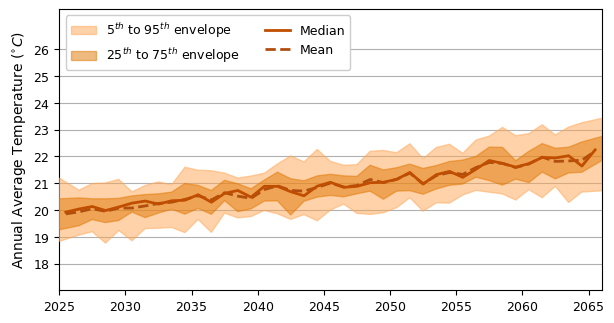

In [69]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, TEnv5to95List, color='xkcd:pale orange', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, TEnv25to75List, color='xkcd:pumpkin', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsTemp.index, FutQsTemp["q0.50"].tolist(), color='xkcd:burnt orange',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsTemp.index, FutQsTemp["Mean"].tolist(), color='xkcd:burnt sienna',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Average Temperature ($^{\circ}C$)', fontsize=10)
ax11.set_yticks( TempYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]) )
ax11.set_ylim( (17, 27.5 ) )
ax11.legend( loc='upper left', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

In [70]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.png" % bas ) )

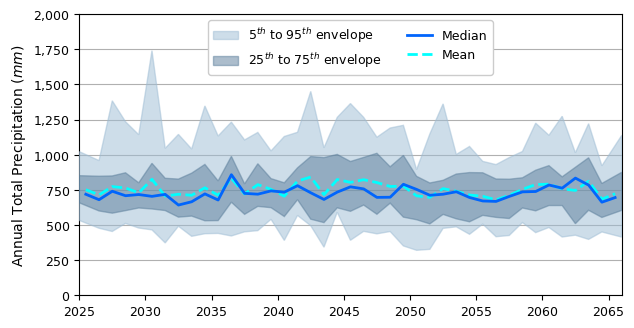

In [71]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, PEnv5to95List, color='xkcd:light grey blue', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, PEnv25to75List, color='xkcd:steel blue', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsPre.index, FutQsPre["q0.50"].tolist(), color='xkcd:bright blue',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsPre.index, FutQsPre["Mean"].tolist(), color='xkcd:cyan',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Total Precipitation ($mm$)', fontsize=10)
ax11.set_yticks( PreYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]))
ax11.set_ylim( (PreYVals[0], PreYVals[len(PreYVals)-1]) )
ax11.legend( loc='upper center', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

### Frio

In [72]:
bCnt += 1
bas = BAS_KEYS[bCnt]
bas

'Frio'

In [73]:
AnnualPreDepDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )
AnnualTempMeanDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )

In [74]:
for mKey in MODEL_KEYS:
    curCol = "M%02d_%s" % (mKey, tSen)
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (mKey, tSen, bas) ) )
    curDF = pd.read_pickle( InFiler )
    cPreDF = curDF[["Year", "Pre_mm"]].copy()
    cTmpDF = curDF[["Year", "AveT_C"]].copy()
    cYrPreDF = cPreDF.groupby(by="Year").sum()
    cYrTmpDF = cTmpDF.groupby(by="Year").mean()
    cYrPreDF = cYrPreDF[(cYrPreDF.index >= StartTS.year) & (cYrPreDF.index <= StopTS.year)].copy()
    cYrTmpDF = cYrTmpDF[(cYrTmpDF.index >= StartTS.year) & (cYrTmpDF.index <= StopTS.year)].copy()
    AnnualPreDepDF[curCol] = cYrPreDF["Pre_mm"].to_numpy(dtype=np.float32)
    AnnualTempMeanDF[curCol] = cYrTmpDF["AveT_C"].to_numpy(dtype=np.float32)
# end for

In [75]:
PreAnnModsDict[bas] = AnnualPreDepDF.copy()
TmpAnnModsDict[bas] = AnnualTempMeanDF.copy()

In [76]:
PreQDict = dict()
AveTQDict = dict()

In [77]:
for cQ in OurQs.tolist():
    curLabel = "q%3.2f" % cQ
    PreQDict[curLabel] = AnnualPreDepDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
    AveTQDict[curLabel] = AnnualTempMeanDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
# end for

In [78]:
PreQDict["Mean"] = AnnualPreDepDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["Mean"] = AnnualTempMeanDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
PreQDict["StDev"] = AnnualPreDepDF.std(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["StDev"] = AnnualTempMeanDF.std(axis=1).to_numpy(dtype=np.float32).flatten()

In [79]:
FutQsPre = pd.DataFrame( index=YearsIndexer, data=PreQDict )
FutQsTemp = pd.DataFrame( index=YearsIndexer, data=AveTQDict )

In [80]:
PreBasinQsDict[bas] = FutQsPre.copy()
TmpBasinQsDict[bas] = FutQsTemp.copy()

In [81]:
PQ5thList = FutQsPre["q0.05"].tolist()
PQ25thList = FutQsPre["q0.25"].tolist()
PQ75thList = FutQsPre["q0.75"].tolist()
PQ95thList = FutQsPre["q0.95"].tolist()

In [82]:
TQ5thList = FutQsTemp["q0.05"].tolist()
TQ25thList = FutQsTemp["q0.25"].tolist()
TQ75thList = FutQsTemp["q0.75"].tolist()
TQ95thList = FutQsTemp["q0.95"].tolist()

In [83]:
# 5th - 95th Envelope
PEnv5to95List = deepcopy( PQ5thList )
Back95List = deepcopy( PQ95thList )
Back95DTTL = Back95List[::-1]
PEnv5to95List.extend( Back95DTTL )

In [84]:
# 25th - 75th Envelope
PEnv25to75List = deepcopy( PQ25thList )
Back75List = deepcopy( PQ75thList )
Back75DTTL = Back75List[::-1]
PEnv25to75List.extend( Back75DTTL )

In [85]:
# 5th - 95th Envelope
TEnv5to95List = deepcopy( TQ5thList )
Back95List = deepcopy( TQ95thList )
Back95DTTL = Back95List[::-1]
TEnv5to95List.extend( Back95DTTL )

In [86]:
# 25th - 75th Envelope
TEnv25to75List = deepcopy( TQ25thList )
Back75List = deepcopy( TQ75thList )
Back75DTTL = Back75List[::-1]
TEnv25to75List.extend( Back75DTTL )

In [87]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.png" % bas ) )

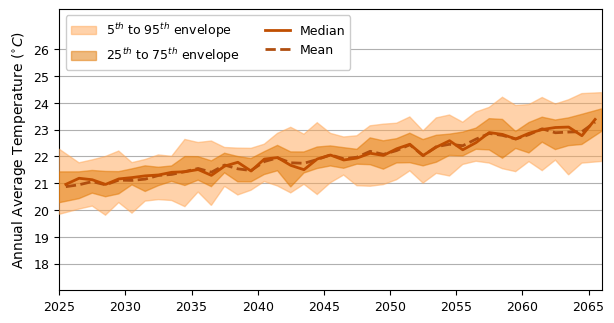

In [88]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, TEnv5to95List, color='xkcd:pale orange', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, TEnv25to75List, color='xkcd:pumpkin', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsTemp.index, FutQsTemp["q0.50"].tolist(), color='xkcd:burnt orange',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsTemp.index, FutQsTemp["Mean"].tolist(), color='xkcd:burnt sienna',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Average Temperature ($^{\circ}C$)', fontsize=10)
ax11.set_yticks( TempYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]) )
ax11.set_ylim( (17, 27.5 ) )
ax11.legend( loc='upper left', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

In [89]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.png" % bas ) )

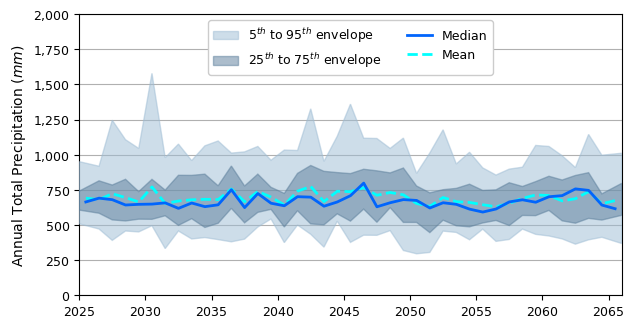

In [90]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, PEnv5to95List, color='xkcd:light grey blue', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, PEnv25to75List, color='xkcd:steel blue', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsPre.index, FutQsPre["q0.50"].tolist(), color='xkcd:bright blue',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsPre.index, FutQsPre["Mean"].tolist(), color='xkcd:cyan',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Total Precipitation ($mm$)', fontsize=10)
ax11.set_yticks( PreYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]))
ax11.set_ylim( (PreYVals[0], PreYVals[len(PreYVals)-1]) )
ax11.legend( loc='upper center', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

### Guadalupe

In [91]:
bCnt += 1
bas = BAS_KEYS[bCnt]
bas

'Guadalupe'

In [92]:
AnnualPreDepDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )
AnnualTempMeanDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )

In [93]:
for mKey in MODEL_KEYS:
    curCol = "M%02d_%s" % (mKey, tSen)
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (mKey, tSen, bas) ) )
    curDF = pd.read_pickle( InFiler )
    cPreDF = curDF[["Year", "Pre_mm"]].copy()
    cTmpDF = curDF[["Year", "AveT_C"]].copy()
    cYrPreDF = cPreDF.groupby(by="Year").sum()
    cYrTmpDF = cTmpDF.groupby(by="Year").mean()
    cYrPreDF = cYrPreDF[(cYrPreDF.index >= StartTS.year) & (cYrPreDF.index <= StopTS.year)].copy()
    cYrTmpDF = cYrTmpDF[(cYrTmpDF.index >= StartTS.year) & (cYrTmpDF.index <= StopTS.year)].copy()
    AnnualPreDepDF[curCol] = cYrPreDF["Pre_mm"].to_numpy(dtype=np.float32)
    AnnualTempMeanDF[curCol] = cYrTmpDF["AveT_C"].to_numpy(dtype=np.float32)
# end for

In [94]:
PreAnnModsDict[bas] = AnnualPreDepDF.copy()
TmpAnnModsDict[bas] = AnnualTempMeanDF.copy()

In [95]:
PreQDict = dict()
AveTQDict = dict()

In [96]:
for cQ in OurQs.tolist():
    curLabel = "q%3.2f" % cQ
    PreQDict[curLabel] = AnnualPreDepDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
    AveTQDict[curLabel] = AnnualTempMeanDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
# end for

In [97]:
PreQDict["Mean"] = AnnualPreDepDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["Mean"] = AnnualTempMeanDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
PreQDict["StDev"] = AnnualPreDepDF.std(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["StDev"] = AnnualTempMeanDF.std(axis=1).to_numpy(dtype=np.float32).flatten()

In [98]:
FutQsPre = pd.DataFrame( index=YearsIndexer, data=PreQDict )
FutQsTemp = pd.DataFrame( index=YearsIndexer, data=AveTQDict )

In [99]:
PreBasinQsDict[bas] = FutQsPre.copy()
TmpBasinQsDict[bas] = FutQsTemp.copy()

In [100]:
PQ5thList = FutQsPre["q0.05"].tolist()
PQ25thList = FutQsPre["q0.25"].tolist()
PQ75thList = FutQsPre["q0.75"].tolist()
PQ95thList = FutQsPre["q0.95"].tolist()

In [101]:
TQ5thList = FutQsTemp["q0.05"].tolist()
TQ25thList = FutQsTemp["q0.25"].tolist()
TQ75thList = FutQsTemp["q0.75"].tolist()
TQ95thList = FutQsTemp["q0.95"].tolist()

In [102]:
# 5th - 95th Envelope
PEnv5to95List = deepcopy( PQ5thList )
Back95List = deepcopy( PQ95thList )
Back95DTTL = Back95List[::-1]
PEnv5to95List.extend( Back95DTTL )

In [103]:
# 25th - 75th Envelope
PEnv25to75List = deepcopy( PQ25thList )
Back75List = deepcopy( PQ75thList )
Back75DTTL = Back75List[::-1]
PEnv25to75List.extend( Back75DTTL )

In [104]:
# 5th - 95th Envelope
TEnv5to95List = deepcopy( TQ5thList )
Back95List = deepcopy( TQ95thList )
Back95DTTL = Back95List[::-1]
TEnv5to95List.extend( Back95DTTL )

In [105]:
# 25th - 75th Envelope
TEnv25to75List = deepcopy( TQ25thList )
Back75List = deepcopy( TQ75thList )
Back75DTTL = Back75List[::-1]
TEnv25to75List.extend( Back75DTTL )

In [106]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.png" % bas ) )

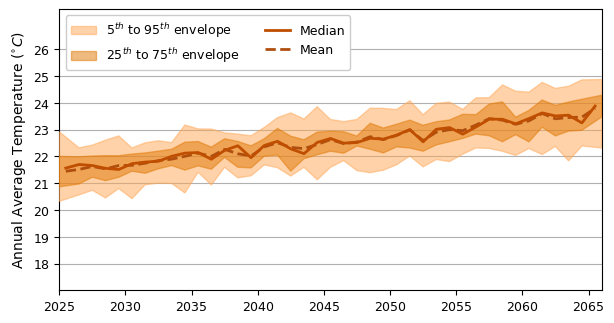

In [107]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, TEnv5to95List, color='xkcd:pale orange', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, TEnv25to75List, color='xkcd:pumpkin', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsTemp.index, FutQsTemp["q0.50"].tolist(), color='xkcd:burnt orange',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsTemp.index, FutQsTemp["Mean"].tolist(), color='xkcd:burnt sienna',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Average Temperature ($^{\circ}C$)', fontsize=10)
ax11.set_yticks( TempYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]) )
ax11.set_ylim( (17, 27.5 ) )
ax11.legend( loc='upper left', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

In [108]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.png" % bas ) )

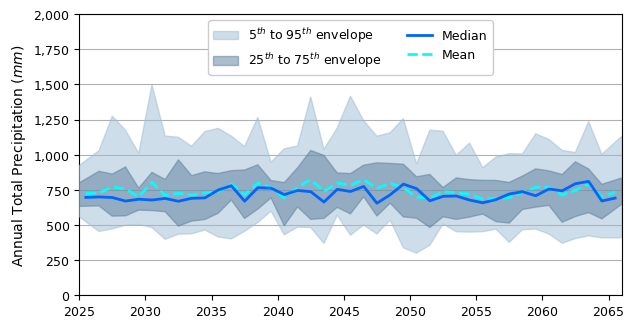

In [109]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, PEnv5to95List, color='xkcd:light grey blue', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, PEnv25to75List, color='xkcd:steel blue', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsPre.index, FutQsPre["q0.50"].tolist(), color='xkcd:bright blue',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsPre.index, FutQsPre["Mean"].tolist(), color='xkcd:cyan',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Total Precipitation ($mm$)', fontsize=10)
ax11.set_yticks( PreYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]))
ax11.set_ylim( (PreYVals[0], PreYVals[len(PreYVals)-1]) )
ax11.legend( loc='upper center', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

### Med-Cib

In [110]:
bCnt += 1
bas = BAS_KEYS[bCnt]
bas

'Med-Cib'

In [111]:
AnnualPreDepDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )
AnnualTempMeanDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )

In [112]:
for mKey in MODEL_KEYS:
    curCol = "M%02d_%s" % (mKey, tSen)
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (mKey, tSen, bas) ) )
    curDF = pd.read_pickle( InFiler )
    cPreDF = curDF[["Year", "Pre_mm"]].copy()
    cTmpDF = curDF[["Year", "AveT_C"]].copy()
    cYrPreDF = cPreDF.groupby(by="Year").sum()
    cYrTmpDF = cTmpDF.groupby(by="Year").mean()
    cYrPreDF = cYrPreDF[(cYrPreDF.index >= StartTS.year) & (cYrPreDF.index <= StopTS.year)].copy()
    cYrTmpDF = cYrTmpDF[(cYrTmpDF.index >= StartTS.year) & (cYrTmpDF.index <= StopTS.year)].copy()
    AnnualPreDepDF[curCol] = cYrPreDF["Pre_mm"].to_numpy(dtype=np.float32)
    AnnualTempMeanDF[curCol] = cYrTmpDF["AveT_C"].to_numpy(dtype=np.float32)
# end for

In [113]:
PreAnnModsDict[bas] = AnnualPreDepDF.copy()
TmpAnnModsDict[bas] = AnnualTempMeanDF.copy()

In [114]:
PreQDict = dict()
AveTQDict = dict()

In [115]:
for cQ in OurQs.tolist():
    curLabel = "q%3.2f" % cQ
    PreQDict[curLabel] = AnnualPreDepDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
    AveTQDict[curLabel] = AnnualTempMeanDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
# end for

In [116]:
PreQDict["Mean"] = AnnualPreDepDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["Mean"] = AnnualTempMeanDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
PreQDict["StDev"] = AnnualPreDepDF.std(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["StDev"] = AnnualTempMeanDF.std(axis=1).to_numpy(dtype=np.float32).flatten()

In [117]:
FutQsPre = pd.DataFrame( index=YearsIndexer, data=PreQDict )
FutQsTemp = pd.DataFrame( index=YearsIndexer, data=AveTQDict )

In [118]:
PreBasinQsDict[bas] = FutQsPre.copy()
TmpBasinQsDict[bas] = FutQsTemp.copy()

In [119]:
PQ5thList = FutQsPre["q0.05"].tolist()
PQ25thList = FutQsPre["q0.25"].tolist()
PQ75thList = FutQsPre["q0.75"].tolist()
PQ95thList = FutQsPre["q0.95"].tolist()

In [120]:
TQ5thList = FutQsTemp["q0.05"].tolist()
TQ25thList = FutQsTemp["q0.25"].tolist()
TQ75thList = FutQsTemp["q0.75"].tolist()
TQ95thList = FutQsTemp["q0.95"].tolist()

In [121]:
# 5th - 95th Envelope
PEnv5to95List = deepcopy( PQ5thList )
Back95List = deepcopy( PQ95thList )
Back95DTTL = Back95List[::-1]
PEnv5to95List.extend( Back95DTTL )

In [122]:
# 25th - 75th Envelope
PEnv25to75List = deepcopy( PQ25thList )
Back75List = deepcopy( PQ75thList )
Back75DTTL = Back75List[::-1]
PEnv25to75List.extend( Back75DTTL )

In [123]:
# 5th - 95th Envelope
TEnv5to95List = deepcopy( TQ5thList )
Back95List = deepcopy( TQ95thList )
Back95DTTL = Back95List[::-1]
TEnv5to95List.extend( Back95DTTL )

In [124]:
# 25th - 75th Envelope
TEnv25to75List = deepcopy( TQ25thList )
Back75List = deepcopy( TQ75thList )
Back75DTTL = Back75List[::-1]
TEnv25to75List.extend( Back75DTTL )

In [125]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.png" % bas ) )

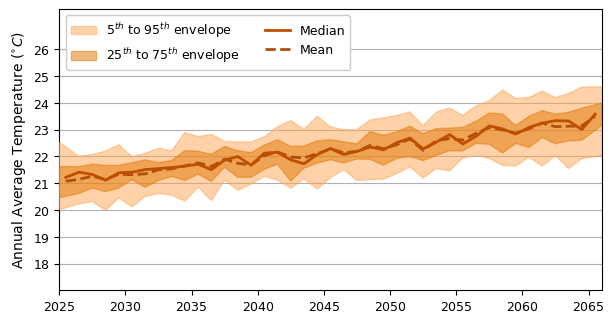

In [126]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, TEnv5to95List, color='xkcd:pale orange', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, TEnv25to75List, color='xkcd:pumpkin', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsTemp.index, FutQsTemp["q0.50"].tolist(), color='xkcd:burnt orange',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsTemp.index, FutQsTemp["Mean"].tolist(), color='xkcd:burnt sienna',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Average Temperature ($^{\circ}C$)', fontsize=10)
ax11.set_yticks( TempYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]) )
ax11.set_ylim( (17, 27.5 ) )
ax11.legend( loc='upper left', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

In [127]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.png" % bas ) )

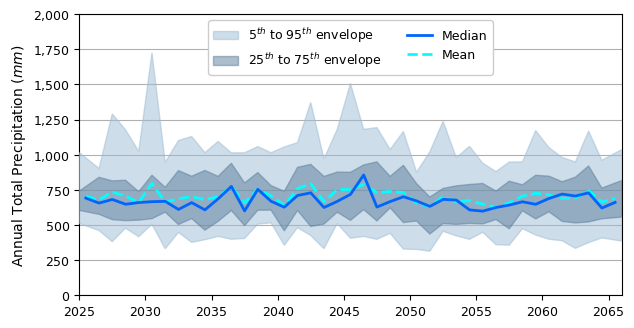

In [128]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, PEnv5to95List, color='xkcd:light grey blue', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, PEnv25to75List, color='xkcd:steel blue', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsPre.index, FutQsPre["q0.50"].tolist(), color='xkcd:bright blue',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsPre.index, FutQsPre["Mean"].tolist(), color='xkcd:cyan',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Total Precipitation ($mm$)', fontsize=10)
ax11.set_yticks( PreYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]))
ax11.set_ylim( (PreYVals[0], PreYVals[len(PreYVals)-1]) )
ax11.legend( loc='upper center', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

### Medina

In [129]:
bCnt += 1
bas = BAS_KEYS[bCnt]
bas

'Medina'

In [130]:
AnnualPreDepDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )
AnnualTempMeanDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )

In [131]:
for mKey in MODEL_KEYS:
    curCol = "M%02d_%s" % (mKey, tSen)
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (mKey, tSen, bas) ) )
    curDF = pd.read_pickle( InFiler )
    cPreDF = curDF[["Year", "Pre_mm"]].copy()
    cTmpDF = curDF[["Year", "AveT_C"]].copy()
    cYrPreDF = cPreDF.groupby(by="Year").sum()
    cYrTmpDF = cTmpDF.groupby(by="Year").mean()
    cYrPreDF = cYrPreDF[(cYrPreDF.index >= StartTS.year) & (cYrPreDF.index <= StopTS.year)].copy()
    cYrTmpDF = cYrTmpDF[(cYrTmpDF.index >= StartTS.year) & (cYrTmpDF.index <= StopTS.year)].copy()
    AnnualPreDepDF[curCol] = cYrPreDF["Pre_mm"].to_numpy(dtype=np.float32)
    AnnualTempMeanDF[curCol] = cYrTmpDF["AveT_C"].to_numpy(dtype=np.float32)
# end for

In [132]:
PreAnnModsDict[bas] = AnnualPreDepDF.copy()
TmpAnnModsDict[bas] = AnnualTempMeanDF.copy()

In [133]:
PreQDict = dict()
AveTQDict = dict()

In [134]:
for cQ in OurQs.tolist():
    curLabel = "q%3.2f" % cQ
    PreQDict[curLabel] = AnnualPreDepDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
    AveTQDict[curLabel] = AnnualTempMeanDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
# end for

In [135]:
PreQDict["Mean"] = AnnualPreDepDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["Mean"] = AnnualTempMeanDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
PreQDict["StDev"] = AnnualPreDepDF.std(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["StDev"] = AnnualTempMeanDF.std(axis=1).to_numpy(dtype=np.float32).flatten()

In [136]:
FutQsPre = pd.DataFrame( index=YearsIndexer, data=PreQDict )
FutQsTemp = pd.DataFrame( index=YearsIndexer, data=AveTQDict )

In [137]:
PreBasinQsDict[bas] = FutQsPre.copy()
TmpBasinQsDict[bas] = FutQsTemp.copy()

In [138]:
PQ5thList = FutQsPre["q0.05"].tolist()
PQ25thList = FutQsPre["q0.25"].tolist()
PQ75thList = FutQsPre["q0.75"].tolist()
PQ95thList = FutQsPre["q0.95"].tolist()

In [139]:
TQ5thList = FutQsTemp["q0.05"].tolist()
TQ25thList = FutQsTemp["q0.25"].tolist()
TQ75thList = FutQsTemp["q0.75"].tolist()
TQ95thList = FutQsTemp["q0.95"].tolist()

In [140]:
# 5th - 95th Envelope
PEnv5to95List = deepcopy( PQ5thList )
Back95List = deepcopy( PQ95thList )
Back95DTTL = Back95List[::-1]
PEnv5to95List.extend( Back95DTTL )

In [141]:
# 25th - 75th Envelope
PEnv25to75List = deepcopy( PQ25thList )
Back75List = deepcopy( PQ75thList )
Back75DTTL = Back75List[::-1]
PEnv25to75List.extend( Back75DTTL )

In [142]:
# 5th - 95th Envelope
TEnv5to95List = deepcopy( TQ5thList )
Back95List = deepcopy( TQ95thList )
Back95DTTL = Back95List[::-1]
TEnv5to95List.extend( Back95DTTL )

In [143]:
# 25th - 75th Envelope
TEnv25to75List = deepcopy( TQ25thList )
Back75List = deepcopy( TQ75thList )
Back75DTTL = Back75List[::-1]
TEnv25to75List.extend( Back75DTTL )

In [144]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.png" % bas ) )

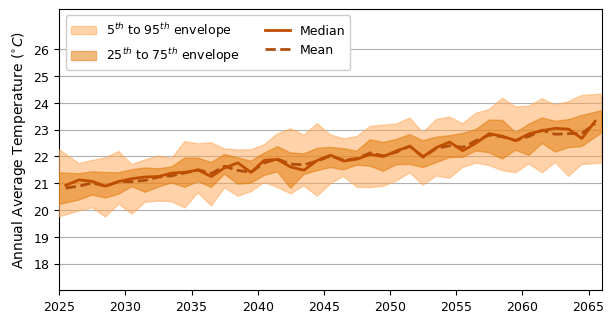

In [145]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, TEnv5to95List, color='xkcd:pale orange', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, TEnv25to75List, color='xkcd:pumpkin', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsTemp.index, FutQsTemp["q0.50"].tolist(), color='xkcd:burnt orange',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsTemp.index, FutQsTemp["Mean"].tolist(), color='xkcd:burnt sienna',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Average Temperature ($^{\circ}C$)', fontsize=10)
ax11.set_yticks( TempYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]) )
ax11.set_ylim( (17, 27.5 ) )
ax11.legend( loc='upper left', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

In [146]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.png" % bas ) )

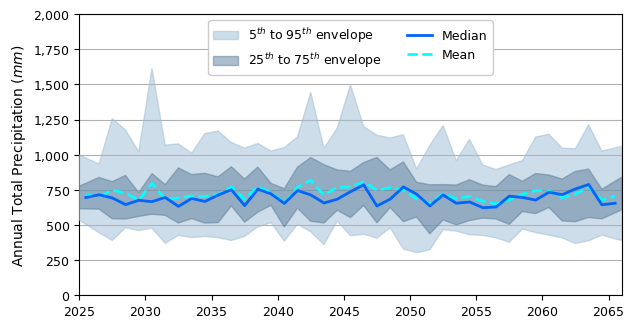

In [147]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, PEnv5to95List, color='xkcd:light grey blue', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, PEnv25to75List, color='xkcd:steel blue', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsPre.index, FutQsPre["q0.50"].tolist(), color='xkcd:bright blue',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsPre.index, FutQsPre["Mean"].tolist(), color='xkcd:cyan',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Total Precipitation ($mm$)', fontsize=10)
ax11.set_yticks( PreYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]))
ax11.set_ylim( (PreYVals[0], PreYVals[len(PreYVals)-1]) )
ax11.legend( loc='upper center', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

### Nueces

In [148]:
bCnt += 1
bas = BAS_KEYS[bCnt]
bas

'Nueces'

In [149]:
AnnualPreDepDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )
AnnualTempMeanDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )

In [150]:
for mKey in MODEL_KEYS:
    curCol = "M%02d_%s" % (mKey, tSen)
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (mKey, tSen, bas) ) )
    curDF = pd.read_pickle( InFiler )
    cPreDF = curDF[["Year", "Pre_mm"]].copy()
    cTmpDF = curDF[["Year", "AveT_C"]].copy()
    cYrPreDF = cPreDF.groupby(by="Year").sum()
    cYrTmpDF = cTmpDF.groupby(by="Year").mean()
    cYrPreDF = cYrPreDF[(cYrPreDF.index >= StartTS.year) & (cYrPreDF.index <= StopTS.year)].copy()
    cYrTmpDF = cYrTmpDF[(cYrTmpDF.index >= StartTS.year) & (cYrTmpDF.index <= StopTS.year)].copy()
    AnnualPreDepDF[curCol] = cYrPreDF["Pre_mm"].to_numpy(dtype=np.float32)
    AnnualTempMeanDF[curCol] = cYrTmpDF["AveT_C"].to_numpy(dtype=np.float32)
# end for

In [151]:
PreAnnModsDict[bas] = AnnualPreDepDF.copy()
TmpAnnModsDict[bas] = AnnualTempMeanDF.copy()

In [152]:
PreQDict = dict()
AveTQDict = dict()

In [153]:
for cQ in OurQs.tolist():
    curLabel = "q%3.2f" % cQ
    PreQDict[curLabel] = AnnualPreDepDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
    AveTQDict[curLabel] = AnnualTempMeanDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
# end for

In [154]:
PreQDict["Mean"] = AnnualPreDepDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["Mean"] = AnnualTempMeanDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
PreQDict["StDev"] = AnnualPreDepDF.std(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["StDev"] = AnnualTempMeanDF.std(axis=1).to_numpy(dtype=np.float32).flatten()

In [155]:
FutQsPre = pd.DataFrame( index=YearsIndexer, data=PreQDict )
FutQsTemp = pd.DataFrame( index=YearsIndexer, data=AveTQDict )

In [156]:
PreBasinQsDict[bas] = FutQsPre.copy()
TmpBasinQsDict[bas] = FutQsTemp.copy()

In [157]:
PQ5thList = FutQsPre["q0.05"].tolist()
PQ25thList = FutQsPre["q0.25"].tolist()
PQ75thList = FutQsPre["q0.75"].tolist()
PQ95thList = FutQsPre["q0.95"].tolist()

In [158]:
TQ5thList = FutQsTemp["q0.05"].tolist()
TQ25thList = FutQsTemp["q0.25"].tolist()
TQ75thList = FutQsTemp["q0.75"].tolist()
TQ95thList = FutQsTemp["q0.95"].tolist()

In [159]:
# 5th - 95th Envelope
PEnv5to95List = deepcopy( PQ5thList )
Back95List = deepcopy( PQ95thList )
Back95DTTL = Back95List[::-1]
PEnv5to95List.extend( Back95DTTL )

In [160]:
# 25th - 75th Envelope
PEnv25to75List = deepcopy( PQ25thList )
Back75List = deepcopy( PQ75thList )
Back75DTTL = Back75List[::-1]
PEnv25to75List.extend( Back75DTTL )

In [161]:
# 5th - 95th Envelope
TEnv5to95List = deepcopy( TQ5thList )
Back95List = deepcopy( TQ95thList )
Back95DTTL = Back95List[::-1]
TEnv5to95List.extend( Back95DTTL )

In [162]:
# 25th - 75th Envelope
TEnv25to75List = deepcopy( TQ25thList )
Back75List = deepcopy( TQ75thList )
Back75DTTL = Back75List[::-1]
TEnv25to75List.extend( Back75DTTL )

In [163]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.png" % bas ) )

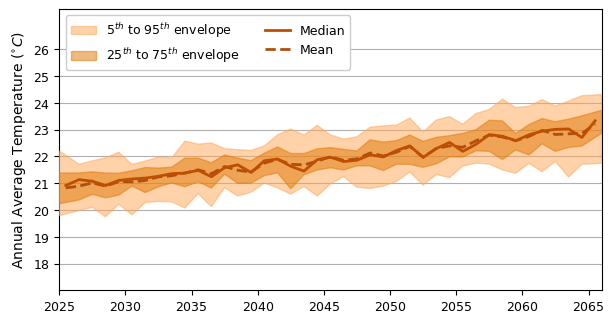

In [164]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, TEnv5to95List, color='xkcd:pale orange', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, TEnv25to75List, color='xkcd:pumpkin', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsTemp.index, FutQsTemp["q0.50"].tolist(), color='xkcd:burnt orange',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsTemp.index, FutQsTemp["Mean"].tolist(), color='xkcd:burnt sienna',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Average Temperature ($^{\circ}C$)', fontsize=10)
ax11.set_yticks( TempYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]) )
ax11.set_ylim( (17, 27.5 ) )
ax11.legend( loc='upper left', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

In [165]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.png" % bas ) )

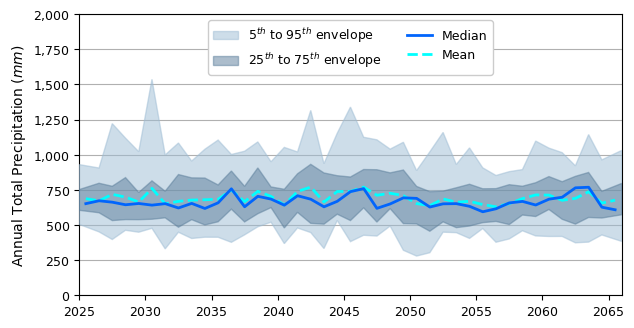

In [166]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, PEnv5to95List, color='xkcd:light grey blue', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, PEnv25to75List, color='xkcd:steel blue', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsPre.index, FutQsPre["q0.50"].tolist(), color='xkcd:bright blue',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsPre.index, FutQsPre["Mean"].tolist(), color='xkcd:cyan',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Total Precipitation ($mm$)', fontsize=10)
ax11.set_yticks( PreYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]))
ax11.set_ylim( (PreYVals[0], PreYVals[len(PreYVals)-1]) )
ax11.legend( loc='upper center', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

### Sab-Med

In [167]:
bCnt += 1
bas = BAS_KEYS[bCnt]
bas

'Sab-Med'

In [168]:
AnnualPreDepDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )
AnnualTempMeanDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )

In [169]:
for mKey in MODEL_KEYS:
    curCol = "M%02d_%s" % (mKey, tSen)
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (mKey, tSen, bas) ) )
    curDF = pd.read_pickle( InFiler )
    cPreDF = curDF[["Year", "Pre_mm"]].copy()
    cTmpDF = curDF[["Year", "AveT_C"]].copy()
    cYrPreDF = cPreDF.groupby(by="Year").sum()
    cYrTmpDF = cTmpDF.groupby(by="Year").mean()
    cYrPreDF = cYrPreDF[(cYrPreDF.index >= StartTS.year) & (cYrPreDF.index <= StopTS.year)].copy()
    cYrTmpDF = cYrTmpDF[(cYrTmpDF.index >= StartTS.year) & (cYrTmpDF.index <= StopTS.year)].copy()
    AnnualPreDepDF[curCol] = cYrPreDF["Pre_mm"].to_numpy(dtype=np.float32)
    AnnualTempMeanDF[curCol] = cYrTmpDF["AveT_C"].to_numpy(dtype=np.float32)
# end for

In [170]:
PreAnnModsDict[bas] = AnnualPreDepDF.copy()
TmpAnnModsDict[bas] = AnnualTempMeanDF.copy()

In [171]:
PreQDict = dict()
AveTQDict = dict()

In [172]:
for cQ in OurQs.tolist():
    curLabel = "q%3.2f" % cQ
    PreQDict[curLabel] = AnnualPreDepDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
    AveTQDict[curLabel] = AnnualTempMeanDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
# end for

In [173]:
PreQDict["Mean"] = AnnualPreDepDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["Mean"] = AnnualTempMeanDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
PreQDict["StDev"] = AnnualPreDepDF.std(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["StDev"] = AnnualTempMeanDF.std(axis=1).to_numpy(dtype=np.float32).flatten()

In [174]:
FutQsPre = pd.DataFrame( index=YearsIndexer, data=PreQDict )
FutQsTemp = pd.DataFrame( index=YearsIndexer, data=AveTQDict )

In [175]:
PreBasinQsDict[bas] = FutQsPre.copy()
TmpBasinQsDict[bas] = FutQsTemp.copy()

In [176]:
PQ5thList = FutQsPre["q0.05"].tolist()
PQ25thList = FutQsPre["q0.25"].tolist()
PQ75thList = FutQsPre["q0.75"].tolist()
PQ95thList = FutQsPre["q0.95"].tolist()

In [177]:
TQ5thList = FutQsTemp["q0.05"].tolist()
TQ25thList = FutQsTemp["q0.25"].tolist()
TQ75thList = FutQsTemp["q0.75"].tolist()
TQ95thList = FutQsTemp["q0.95"].tolist()

In [178]:
# 5th - 95th Envelope
PEnv5to95List = deepcopy( PQ5thList )
Back95List = deepcopy( PQ95thList )
Back95DTTL = Back95List[::-1]
PEnv5to95List.extend( Back95DTTL )

In [179]:
# 25th - 75th Envelope
PEnv25to75List = deepcopy( PQ25thList )
Back75List = deepcopy( PQ75thList )
Back75DTTL = Back75List[::-1]
PEnv25to75List.extend( Back75DTTL )

In [180]:
# 5th - 95th Envelope
TEnv5to95List = deepcopy( TQ5thList )
Back95List = deepcopy( TQ95thList )
Back95DTTL = Back95List[::-1]
TEnv5to95List.extend( Back95DTTL )

In [181]:
# 25th - 75th Envelope
TEnv25to75List = deepcopy( TQ25thList )
Back75List = deepcopy( TQ75thList )
Back75DTTL = Back75List[::-1]
TEnv25to75List.extend( Back75DTTL )

In [182]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.png" % bas ) )

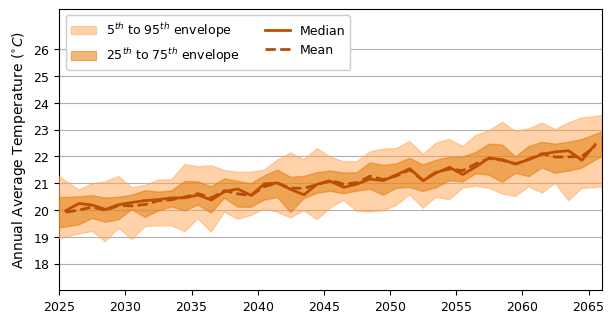

In [183]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, TEnv5to95List, color='xkcd:pale orange', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, TEnv25to75List, color='xkcd:pumpkin', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsTemp.index, FutQsTemp["q0.50"].tolist(), color='xkcd:burnt orange',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsTemp.index, FutQsTemp["Mean"].tolist(), color='xkcd:burnt sienna',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Average Temperature ($^{\circ}C$)', fontsize=10)
ax11.set_yticks( TempYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]) )
ax11.set_ylim( (17, 27.5 ) )
ax11.legend( loc='upper left', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

In [184]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.png" % bas ) )

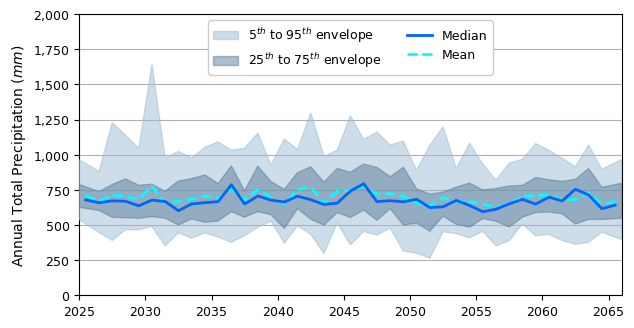

In [185]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, PEnv5to95List, color='xkcd:light grey blue', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, PEnv25to75List, color='xkcd:steel blue', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsPre.index, FutQsPre["q0.50"].tolist(), color='xkcd:bright blue',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsPre.index, FutQsPre["Mean"].tolist(), color='xkcd:cyan',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Total Precipitation ($mm$)', fontsize=10)
ax11.set_yticks( PreYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]))
ax11.set_ylim( (PreYVals[0], PreYVals[len(PreYVals)-1]) )
ax11.legend( loc='upper center', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

### Sabinal

In [186]:
bCnt += 1
bas = BAS_KEYS[bCnt]
bas, bCnt

('Sabinal', 8)

In [187]:
AnnualPreDepDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )
AnnualTempMeanDF = pd.DataFrame( 0.0, index=YearsIndexer, columns=ColsList, dtype=np.float32 )

In [188]:
for mKey in MODEL_KEYS:
    curCol = "M%02d_%s" % (mKey, tSen)
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (mKey, tSen, bas) ) )
    curDF = pd.read_pickle( InFiler )
    cPreDF = curDF[["Year", "Pre_mm"]].copy()
    cTmpDF = curDF[["Year", "AveT_C"]].copy()
    cYrPreDF = cPreDF.groupby(by="Year").sum()
    cYrTmpDF = cTmpDF.groupby(by="Year").mean()
    cYrPreDF = cYrPreDF[(cYrPreDF.index >= StartTS.year) & (cYrPreDF.index <= StopTS.year)].copy()
    cYrTmpDF = cYrTmpDF[(cYrTmpDF.index >= StartTS.year) & (cYrTmpDF.index <= StopTS.year)].copy()
    AnnualPreDepDF[curCol] = cYrPreDF["Pre_mm"].to_numpy(dtype=np.float32)
    AnnualTempMeanDF[curCol] = cYrTmpDF["AveT_C"].to_numpy(dtype=np.float32)
# end for

In [189]:
PreAnnModsDict[bas] = AnnualPreDepDF.copy()
TmpAnnModsDict[bas] = AnnualTempMeanDF.copy()

In [190]:
PreQDict = dict()
AveTQDict = dict()

In [191]:
for cQ in OurQs.tolist():
    curLabel = "q%3.2f" % cQ
    PreQDict[curLabel] = AnnualPreDepDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
    AveTQDict[curLabel] = AnnualTempMeanDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
# end for

In [192]:
PreQDict["Mean"] = AnnualPreDepDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["Mean"] = AnnualTempMeanDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
PreQDict["StDev"] = AnnualPreDepDF.std(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["StDev"] = AnnualTempMeanDF.std(axis=1).to_numpy(dtype=np.float32).flatten()

In [193]:
FutQsPre = pd.DataFrame( index=YearsIndexer, data=PreQDict )
FutQsTemp = pd.DataFrame( index=YearsIndexer, data=AveTQDict )

In [194]:
PreBasinQsDict[bas] = FutQsPre.copy()
TmpBasinQsDict[bas] = FutQsTemp.copy()

In [195]:
PQ5thList = FutQsPre["q0.05"].tolist()
PQ25thList = FutQsPre["q0.25"].tolist()
PQ75thList = FutQsPre["q0.75"].tolist()
PQ95thList = FutQsPre["q0.95"].tolist()

In [196]:
TQ5thList = FutQsTemp["q0.05"].tolist()
TQ25thList = FutQsTemp["q0.25"].tolist()
TQ75thList = FutQsTemp["q0.75"].tolist()
TQ95thList = FutQsTemp["q0.95"].tolist()

In [197]:
# 5th - 95th Envelope
PEnv5to95List = deepcopy( PQ5thList )
Back95List = deepcopy( PQ95thList )
Back95DTTL = Back95List[::-1]
PEnv5to95List.extend( Back95DTTL )

In [198]:
# 25th - 75th Envelope
PEnv25to75List = deepcopy( PQ25thList )
Back75List = deepcopy( PQ75thList )
Back75DTTL = Back75List[::-1]
PEnv25to75List.extend( Back75DTTL )

In [199]:
# 5th - 95th Envelope
TEnv5to95List = deepcopy( TQ5thList )
Back95List = deepcopy( TQ95thList )
Back95DTTL = Back95List[::-1]
TEnv5to95List.extend( Back95DTTL )

In [200]:
# 25th - 75th Envelope
TEnv25to75List = deepcopy( TQ25thList )
Back75List = deepcopy( TQ75thList )
Back75DTTL = Back75List[::-1]
TEnv25to75List.extend( Back75DTTL )

In [201]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.png" % bas ) )

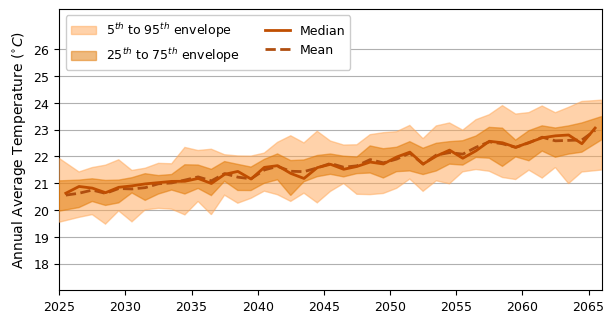

In [202]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, TEnv5to95List, color='xkcd:pale orange', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, TEnv25to75List, color='xkcd:pumpkin', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsTemp.index, FutQsTemp["q0.50"].tolist(), color='xkcd:burnt orange',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsTemp.index, FutQsTemp["Mean"].tolist(), color='xkcd:burnt sienna',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Average Temperature ($^{\circ}C$)', fontsize=10)
ax11.set_yticks( TempYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]) )
ax11.set_ylim( (17, 27.5 ) )
ax11.legend( loc='upper left', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

In [203]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.pdf" % bas ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.svg" % bas ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.png" % bas ) )

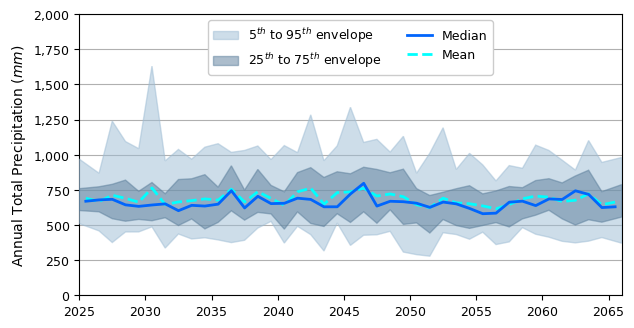

In [204]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, PEnv5to95List, color='xkcd:light grey blue', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, PEnv25to75List, color='xkcd:steel blue', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsPre.index, FutQsPre["q0.50"].tolist(), color='xkcd:bright blue',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsPre.index, FutQsPre["Mean"].tolist(), color='xkcd:cyan',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Total Precipitation ($mm$)', fontsize=10)
ax11.set_yticks( PreYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]))
ax11.set_ylim( (PreYVals[0], PreYVals[len(PreYVals)-1]) )
ax11.legend( loc='upper center', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

## Output to a Spreadsheet

In [205]:
OutFiler = os.path.normpath( os.path.join( OUT_DIR, "Cones_of_Uncertainty_LOCA2_%s_2025to2065.xlsx" % tSen ) )
writer = pd.ExcelWriter( OutFiler )
workbook  = writer.book
format1 = workbook.add_format({'num_format': '#,##0.00'})
for bas in BAS_KEYS:
    curModTmp = TmpAnnModsDict[bas]
    curModPre = PreAnnModsDict[bas]
    curBStatsTmp = TmpBasinQsDict[bas]
    curBStatsPre = PreBasinQsDict[bas]
    cLabel = "%s_AnnAve_Temp" % bas
    curModTmp.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
    # adjust columns
    writer.sheets[cLabel].set_column( 0, 0, 18 )
    for column in curModTmp:
        column_width = max(curModTmp[column].astype(str).map(len).max()+6, len(column)+6)
        col_idx = curModTmp.columns.get_loc(column)
        writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
    # end for
    cLabel = "%s_AnnTot_Pre" % bas
    curModPre.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
    # adjust columns
    writer.sheets[cLabel].set_column( 0, 0, 18 )
    for column in curModPre:
        column_width = max(curModPre[column].astype(str).map(len).max()+6, len(column)+6)
        col_idx = curModPre.columns.get_loc(column)
        writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
    # end for
    cLabel = "%s_Temp_Stats" % bas
    curBStatsTmp.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
    # adjust columns
    writer.sheets[cLabel].set_column( 0, 0, 18 )
    for column in curBStatsTmp:
        column_width = max(curBStatsTmp[column].astype(str).map(len).max()+6, len(column)+6)
        col_idx = curBStatsTmp.columns.get_loc(column)
        writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
    # end for
    cLabel = "%s_Pre_Stats" % bas
    curBStatsPre.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
    # adjust columns
    writer.sheets[cLabel].set_column( 0, 0, 18 )
    for column in curBStatsPre:
        column_width = max(curBStatsPre[column].astype(str).map(len).max()+6, len(column)+6)
        col_idx = curBStatsPre.columns.get_loc(column)
        writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
    # end for
# end for
writer.close()